# 导入数据

In [57]:
import pandas as pd
import backtrader as bt
import yfinance as yf
import matplotlib.pyplot as plt

In [58]:
dt_goog = yf.Ticker('GOOG').history(period='5Y', auto_adjust=True, repair=True)
dt_amzn = yf.Ticker('AMZN').history(period='5Y', auto_adjust=True, repair=True)
dt_aapl = yf.Ticker('AAPL').history(period='5Y', auto_adjust=True, repair=True)
dt_meta = yf.Ticker('META').history(period='5Y', auto_adjust=True, repair=True)
dt_msft = yf.Ticker('MSFT').history(period='5Y', auto_adjust=True, repair=True)
dt_nvda = yf.Ticker('NVDA').history(period='5Y', auto_adjust=True, repair=True)
dt_tsla = yf.Ticker('TSLA').history(period='5Y', auto_adjust=True, repair=True)

# 定义策略  
- 相对动量策略
- 周期为120个交易日
- 再平衡（1-12月）
- 开仓动量阈值（0.0）
- 选择标的资产数量（1）

In [ ]:
class RelativeMomentumStrategy(bt.Strategy):
    params = (
        ('momentum_period', 30 * 4),
        ('top_n', 1),
        ('rebalance_months', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] ),
        ('long_only_momentum_threshold', 0.0))

    def __init__(self):      
        self.momenta = []
        for i, data in enumerate(self.datas):
            self.momenta.append(bt.indicators.ROC100(data.close, period=self.p.momentum_period))
        # 初始化再平衡月份
        self.last_rebalance_month = None
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # 订单已提交或被接受，等待执行
            return
        # 订单完成 (买入/卖出)
        if order.status in [order.Completed]:
            if order.isbuy():
                print(f"买入执行 - {order.data._name} - 日期: {self.data.datetime.date()}, "
                      f"价格: {order.executed.price:.2f}, 数量: {order.executed.size:.0f}, "
                      f"成本: {order.executed.value:.2f}, 佣金: {order.executed.comm:.2f}")
            elif order.issell():
                print(f"卖出执行 - {order.data._name} - 日期: {self.data.datetime.date()}, "
                      f"价格: {order.executed.price:.2f}, 数量: {order.executed.size:.0f}, "
                      f"成本: {order.executed.value:.2f}, 佣金: {order.executed.comm:.2f}")
        # 订单取消、保证金不足、拒绝等状态
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print(f"订单状态: {order.Status[order.status]} - {order.data._name} - 日期: {self.data.datetime.date()}")
        # 重置 self.order，以便可以发出新的订单
        # 注意：在多资产策略中，此处的 self.order 仅代表最近一个订单，
        # 如果需要更复杂的订单管理，需要维护一个订单列表或字典。
        self.order = None

    def notify_trade(self, trade):
        # 交易完成（平仓）时调用
        if not trade.isclosed:
            return
        print(f"交易完成 - {trade.data._name} - 毛利润: {trade.pnl:.2f}, 净利润: {trade.pnlcomm:.2f}")

    def next(self):
        # ====确保有足够数据====
        if any(len(self.data) < self.p.momentum_period for data in self.datas):
            return
        # 如果有未完成的订单，等待其完成 (简化的处理方式，在复杂多资产中可能需要更细致的判断)
        if self.order and self.order.status in [self.order.Submitted, self.order.Accepted]:
            return
        
        # ====判断是否为再平衡周期
        current_month = self.datetime.date().month
        if current_month in self.p.rebalance_months and current_month != self.last_rebalance_month:
            # 重置上一次再平衡月份
            self.last_rebalance_month = current_month
            ranked_assets = []
            for i, data in enumerate(self.datas):
                # 再次检查数据是否准备好，确保指标有值
                if len(data) < self.p.momentum_period:
                    continue # 如果这个数据源还没准备好，跳过它
                momentum_value = self.momenta[i][0] # 获取当前动量值
                # 只有当动量值大于我们定义的最低阈值时，才考虑这个资产
                if momentum_value > self.p.long_only_momentum_threshold:
                    ranked_assets.append((momentum_value, data))
            # 根据动量值从高到低排序
            ranked_assets.sort(key=lambda x: x[0], reverse=True)
            # ====确定目标资产====
            # 选出动量最高的 N 个资产
            target_assets = [item[1] for item in ranked_assets[:self.p.top_n]]
            # 打印当前所有资产的动量 (调试用)
            print(f"--- {self.datetime.date()} - 再平衡开始 ---")
            for m_val, data_item in ranked_assets:
                print(f"  资产: {data_item._name}, 动量: {m_val:.2f}%")
            print(f"  目标资产: {[data._name for data in target_assets]}")
            # ====卖出/平仓逻辑 (先处理要卖出的) ====
            # 遍历当前所有持仓
            for data in self.datas: # 遍历所有可能持有或想持有的数据源
                # 检查这个数据源是否有持仓
                if self.getposition(data).size > 0: # 如果对这个资产有持仓
                    # 并且这个资产不在我们的目标资产列表中
                    if data not in target_assets:
                        self.close(data=data) # 平仓这个资产
                        print(f"  平仓: {data._name} - 不再是目标资产")
            # ====买入逻辑 (再处理要买入的) ====
            # 为了简化，我们假设将所有可用资金分配给选中的资产
            # 如果选了多个，就均分
            if target_assets: # 确保有目标资产可以买入
                cash_per_asset = self.broker.getcash() / len(target_assets)
                for data in target_assets:
                    # 如果还没有持仓，就买入
                    if self.getposition(data).size == 0:
                        # 计算可以买入的股数（为了简单，这里直接买入，你可以考虑更多细节）
                        # 确保有足够的资金
                        if cash_per_asset > data.close[0]:
                            # 计算可买入的整数股数
                            size_to_buy = int(cash_per_asset // data.close[0])
                            if size_to_buy > 0: # 确保计算出来的数量大于0
                                self.buy(data=data, size=size_to_buy)
                                print(f"  执行买入: {data._name}, 数量: {size_to_buy:.0f} @ {data.close[0]:.2f}")
                    # else: 已经持有目标资产，不需要操作 (或者可以考虑再平衡持仓比例)
            else: # 如果没有目标资产（所有资产动量都小于阈值），保持空仓
                 print("  所有资产动量均不符合要求，保持空仓。")
        # ----------------------------------------------------
        # 如果不是再平衡时间，我们也可以在这里加入其他逻辑，例如止损
        # 但对于相对动量策略，通常只在再平衡时进行交易决策
        # ----------------------------------------------------

初始资金: 100000.00
--- 2020-12-31 - 再平衡开始 ---
  资产: TSLA, 动量: 75.17%
  资产: GOOG, 动量: 10.31%
  资产: AAPL, 动量: 5.61%
  资产: MSFT, 动量: 4.36%
  资产: NVDA, 动量: 2.69%
  资产: META, 动量: 0.65%
  目标资产: ['TSLA']
  执行买入: TSLA, 数量: 425 @ 235.22
订单状态: Margin - TSLA - 日期: 2021-01-04
--- 2021-01-04 - 再平衡开始 ---
  资产: TSLA, 动量: 80.34%
  资产: GOOG, 动量: 7.46%
  资产: AAPL, 动量: 3.85%
  资产: NVDA, 动量: 2.91%
  资产: MSFT, 动量: 0.83%
  目标资产: ['TSLA']
  执行买入: TSLA, 数量: 411 @ 243.26
买入执行 - TSLA - 日期: 2021-01-05, 价格: 241.22, 数量: 411, 成本: 99141.42, 佣金: 9.91
--- 2021-02-01 - 再平衡开始 ---
  资产: TSLA, 动量: 97.96%
  资产: GOOG, 动量: 29.74%
  资产: AAPL, 动量: 20.18%
  资产: MSFT, 动量: 15.84%
  资产: AMZN, 动量: 6.84%
  资产: NVDA, 动量: 4.77%
  资产: META, 动量: 2.85%
  目标资产: ['TSLA']
--- 2021-03-01 - 再平衡开始 ---
  资产: TSLA, 动量: 66.75%
  资产: GOOG, 动量: 35.64%
  资产: MSFT, 动量: 11.15%
  资产: AAPL, 动量: 10.54%
  资产: NVDA, 动量: 2.58%
  资产: META, 动量: 1.34%
  目标资产: ['TSLA']
--- 2021-04-01 - 再平衡开始 ---
  资产: TSLA, 动量: 32.54%
  资产: GOOG, 动量: 21.19%
  资产: MSFT, 动量: 14.35%


<IPython.core.display.Javascript object>

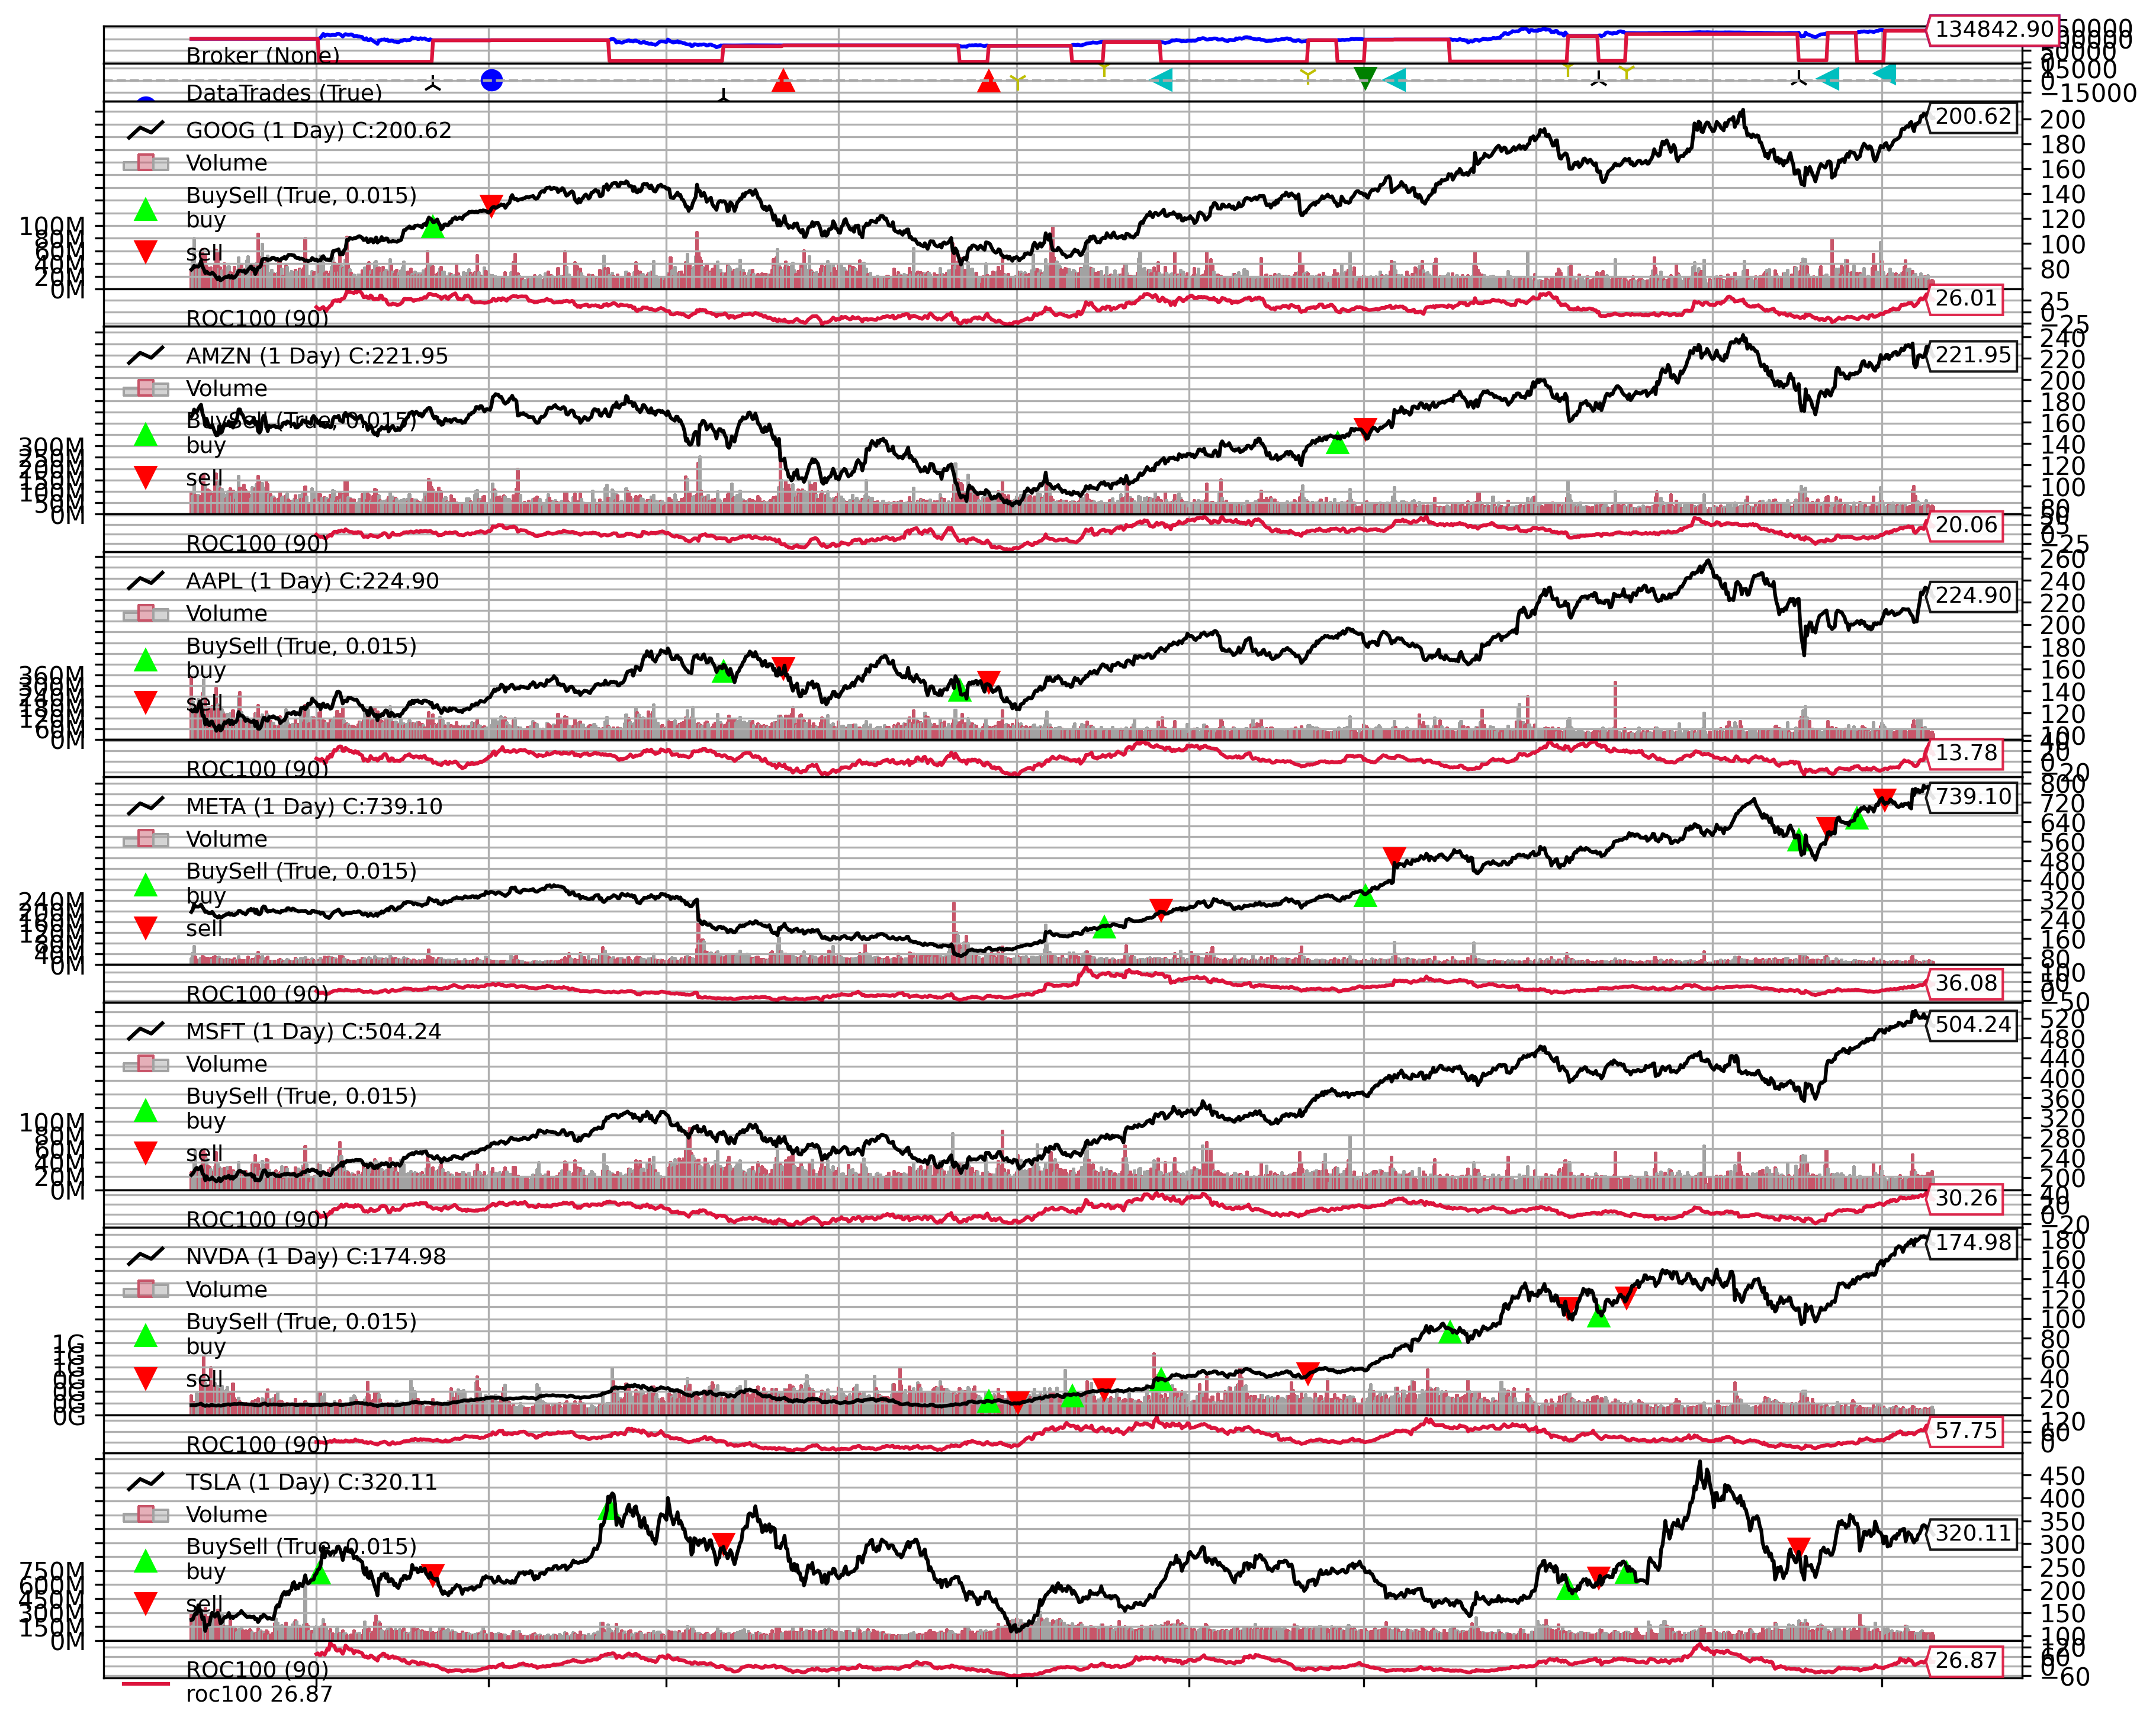

In [60]:

cerebro = bt.Cerebro()
cerebro.adddata(bt.feeds.PandasData(dataname=dt_goog), name='GOOG')
cerebro.adddata(bt.feeds.PandasData(dataname=dt_amzn), name='AMZN')
cerebro.adddata(bt.feeds.PandasData(dataname=dt_aapl), name='AAPL')
cerebro.adddata(bt.feeds.PandasData(dataname=dt_meta), name='META')
cerebro.adddata(bt.feeds.PandasData(dataname=dt_msft), name='MSFT')
cerebro.adddata(bt.feeds.PandasData(dataname=dt_nvda), name='NVDA')
cerebro.adddata(bt.feeds.PandasData(dataname=dt_tsla), name='TSLA')
cerebro.addstrategy(RelativeMomentumStrategy, top_n=1)

# 设置初始资金
cerebro.broker.setcash(100000.0)
# 设置佣金 (这里设置为万分之一，可以根据实际情况调整)
cerebro.broker.setcommission(commission=0.0001)

# 打印初始资金
print(f"初始资金: {cerebro.broker.getvalue():.2f}")
# 运行回测
cerebro.run()
# 打印最终资金
print(f"最终资金: {cerebro.broker.getvalue():.2f}")
# 绘制回测结果
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 300
cerebro.plot()[0][0]